In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
lonMin = (float)(config['TP_SEC_ORDER']['LON_MIN'])
lonMax = (float)(config['TP_SEC_ORDER']['LON_MAX'])

latMin = (float)(config['TP_SEC_ORDER']['LAT_MIN'])
latMax = (float)(config['TP_SEC_ORDER']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['TP_SEC_ORDER']['INCR_STEP'])
incrRes = (int)(config['TP_SEC_ORDER']['INCR_RES'])

fileDir = config['TP_SEC_ORDER']['SOURCE_DIR']
dirToStore = config['TP_SEC_ORDER']['DEST_DIR']

print("SOURCE_DIR = %s"%fileDir)
print("DEST_DIR = %s"%dirToStore)

-120.5 33.9
-119.0 34.44
SOURCE_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/
DEST_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/SparseTP/


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [7]:
opFile = dirToStore + 'TPM.npz'
# opFile = dirToStore + 'TPM_.npz'
tpMatrix = scipy.sparse.load_npz(opFile)

# opFile = dirToStore + 'TPM.npy'
# tpMatrix = np.load(opFile)

In [8]:
print(tpMatrix.sum())

37417.0


In [9]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

In [10]:
#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStatus):
    return (vesselStatus.T @ tpMatrix).flatten()

In [11]:
def generate_vessel_prev_cur_status(prevState,currState):
    vesselState = np.zeros((totalStates*totalStates))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

In [ ]:
oneVessel = "../Data/M120_50_M119_00_33_90_34_38/MMSI/566952000_Sorted.csv"
# oneVessel = "../Data/M120_00_M119_50_34_12_34_24/MMSI/636012801_Sorted.csv"
# oneVessel = "../Data/M119_50_M119_00_34_00_34_16/MMSI/367353080_Sorted.csv"
# oneVessel = "../Data/M119_50_M119_00_34_00_34_16/MMSI/636012801_Sorted.csv"
oneVesselData,_ = aISDM.load_data_from_csv(oneVessel)
print(oneVesselData.shape)
oneVesselLon = oneVesselData['LON']
oneVesselLat = oneVesselData['LAT']
plt.plot(oneVesselLon,oneVesselLat)

In [ ]:
oneVesselTime = oneVesselData['DateTime']
for i in range(oneVesselLon.shape[0]):
    print(i,oneVesselTime[i])

In [ ]:
timeIntervalList = "../Data/M120_50_M119_00_33_90_34_38/TimeInterval/HalfHourIntvl1701To1702.txt"
# timeIntervalList = "../Data/M120_50_M119_00_33_90_34_38/TimeInterval/HalfHourIntvl1702To1703.txt"
timeWindows = [line.rstrip('\n') for line in open(timeIntervalList)]

In [ ]:
#get the last instance of the position data 
#for one of the vessel
#and that can be used for the prediction
oneVesselLastData = pd.DataFrame()
#based on time stamps 
for timeSlot in timeWindows:
    temp = timeSlot.split(',')
    startTime = temp[0]
    endTime = temp[1]

    timelyDF = aISDM.filter_based_on_time_stamp(oneVesselData,'DateTime',startTime,endTime)
    oneVesselRows = timelyDF.shape[0]
    
    invertedTimelyDF = aISDM.inver_df(timelyDF)
    invertedTimelyDF = invertedTimelyDF.drop_duplicates(subset="MMSI")
    
    oneVesselLastData = oneVesselLastData.append(invertedTimelyDF, ignore_index = True)

In [ ]:
oneVesselTime = oneVesselLastData['DateTime']
for i in range(oneVesselTime.shape[0]):
    print(i,oneVesselTime[i])

In [ ]:
#divide the journey into two parts
#part 1 is from 0 to 16 included
#part 2 is from 17 to 42 included
oneVesselLastDataOne = oneVesselLastData.iloc[0:17,:]
oneVesselLastDataTwo = oneVesselLastData.iloc[17:,:]

# oneVesselLastDataOne = oneVesselLastData.iloc[0:4,:]

In [ ]:
print(oneVesselLastDataOne)

In [ ]:
print(oneVesselLastDataTwo)

In [34]:
oneVessel = "../Data/M120_50_M119_00_33_90_34_44/MMSIContainer/100.csv"
oneVesselLastDataOne,_ = aISDM.load_data_from_csv(oneVessel)

In [35]:
print(oneVesselLastDataOne)

         MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0   209251000  2017-04-29T14:09:58  33.98187 -119.07240  12.0 -110.6    302.0   
1   209251000  2017-04-29T14:39:41  34.03865 -119.18947  14.2 -111.6    301.0   
2   209251000  2017-04-29T15:09:33  34.08547 -119.31682  13.7 -124.6    288.0   
3   209251000  2017-04-29T15:39:02  34.11742 -119.44837  13.7 -123.6    287.0   
4   209251000  2017-04-29T16:09:21  34.15058 -119.58280  13.7 -122.6    287.0   
5   209251000  2017-04-29T16:39:01  34.18063 -119.71417  13.7 -125.6    284.0   
6   209251000  2017-04-29T17:09:02  34.20905 -119.84893  13.9 -125.6    284.0   
7   209251000  2017-04-29T17:39:11  34.23888 -119.98263  13.5 -124.6    284.0   
8   209251000  2017-04-29T18:09:04  34.26672 -120.11592  14.0 -126.6    285.0   
9   209251000  2017-04-29T18:39:40  34.29775 -120.25558  13.9 -123.6    287.0   
10  209251000  2017-04-29T19:09:10  34.32823 -120.38932  14.0 -125.6    287.0   
11  209251000  2017-04-29T19

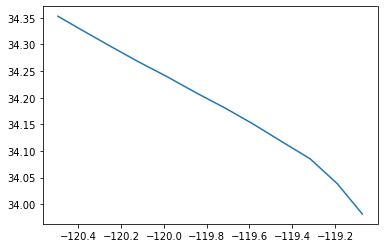

In [36]:
oneVesselLastDataOneLon = oneVesselLastDataOne["LON"]
oneVesselLastDataOneLat = oneVesselLastDataOne["LAT"]
plt.plot(oneVesselLastDataOneLon,oneVesselLastDataOneLat)

In [22]:
oneVesselLastDataTwoLon = oneVesselLastDataTwo["LON"]
oneVesselLastDataTwoLat = oneVesselLastDataTwo["LAT"]
plt.plot(oneVesselLastDataTwoLon,oneVesselLastDataTwoLat)

NameError: name 'oneVesselLastDataTwo' is not defined

In [23]:
def generate_vessel_prev_cur_status_(prevState,currState):
    vesselState = np.zeros((prevState.shape[0]*currState.shape[0]))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

In [ ]:
# from scipy.io import savemat
# from scipy import sparse
# vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
# vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
# savemat('VesselPrev', {'M':vesselPrevState})
# savemat('VesselCurr', {'M':vesselCurrState})
# savemat('TrPM', {'M':tpMatrix})

In [24]:
rowSum = np.sum(tpMatrix, axis=1)
rowSumZeroIdx = np.argwhere(rowSum == 0)
rowSumZeroIdx = rowSumZeroIdx.flatten()

In [37]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
onePredict = []
for i in range(9):
    vesselProbState = generate_path(vesselState)
    print(i)
    print(np.sum(vesselProbState))
    onePredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    #make probabilities zero
    vesselState[rowSumZeroIdx] = 0
    vesselState = vesselState/np.sum(vesselState)
    print(np.sum(vesselState))

0
0.9999999999999999
1.0000000000000002
1
1.0000000000000002
1.0
2
0.9999999999999999
0.9999999999999994
3
0.9999999999999996
1.0000000000000002
4
0.9999999999999998
0.9999999999999989
5
0.9999999999999994
0.9999999999999999
6
0.9999999999999992
0.9999999999999996
7
0.9999999999999993
1.0000000000000002
8
1.0000000000000004
1.0000000000000004


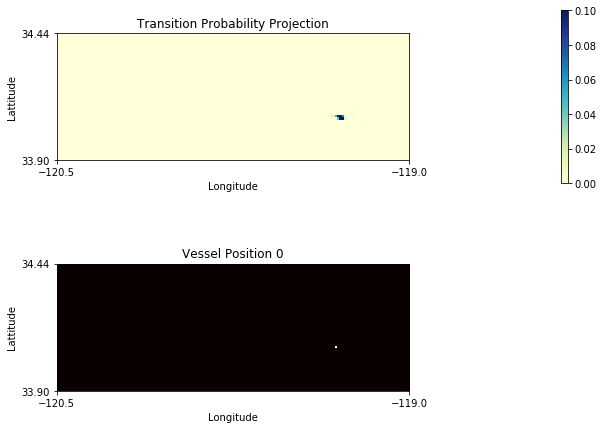

In [38]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataOneLon.iloc[i+2],oneVesselLastDataOneLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
#     vesselProbState = generate_path(vesselState)
#     #copy the file
#     vesselPrevState = vesselCurrState.copy()
#     vesselCurrState = vesselProbState.copy()
#     vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    
    vesselProbState = onePredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.1)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=9, interval=1000)

In [39]:
HTML(anim.to_html5_video())

In [28]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [40]:
# anim.save('TPSeqOneSecOrder.mp4', writer=writer)
anim.save('TPSeqTwoSecOrder.mp4', writer=writer)

In [ ]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
twoPredict = []
for i in range(20):
    vesselProbState = generate_path(vesselState)
    print(i)
    print(np.sum(vesselProbState))
    twoPredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    
    vesselState[rowSumZeroIdx] = 0
    vesselState = vesselState/np.sum(vesselState)

In [ ]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[i+2],oneVesselLastDataTwoLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    
    vesselProbState = twoPredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.1)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=20, interval=1000)


In [ ]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('TPSeqTwoSecOrder.mp4', writer=writer)